# Predicting House Prices in Toronto, Ontario

In [1]:
# import necessary libraries
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pgeocode
from glob import glob
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from ipywidgets import Dropdown, FloatSlider, IntSlider, FloatText, interact
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
import warnings

In [2]:
warnings.filterwarnings('ignore')

## Prepare Data

### Import

In [3]:
def wrangle(filepath):
    
    # import file
    df = pd.read_csv(filepath)
    
    # drop duplicates
    df.drop_duplicates('mls_number')
    
    # clean price column and make dtype float
    df['price'] = df['price'].apply(
        lambda x: re.sub(r"[$,]", "", str(x))).astype(float)
    
    # remove outliers in price by values in the bottom and top 5% of properties
    low, high = df['price'].quantile([0.05, 0.95])
    mask_area = df['price'].between(low, high)
    df = df[mask_area]
    
    # make postcode column, remove address column
    df['postcode'] = df['address'].apply(
        lambda x: re.findall(r"M[0-9]\D[0-9]\D[0-9]", str(x)))
    df['postcode'] = df.postcode.str[0].astype(str)
    def insert_space(string):
        return string[0:3] + ' ' + string[3:]
    df['postcode'] = df.postcode.apply(insert_space)
    
    # make badrooms column. remove above and below grade bedroom columns
    df['above_grade_bedrooms'] = df['above_grade_bedrooms'].fillna(0).apply(
        lambda x: re.findall(r"[0-9]+", str(x)))
    df['below_grade_bedrooms'] = df['below_grade_bedrooms'].fillna(0).apply(
        lambda x: re.findall(r"[0-9]+", str(x)))
    df['above_grade_bedrooms'] = df.above_grade_bedrooms.str[0].astype(int)
    df['below_grade_bedrooms'] = df.below_grade_bedrooms.str[0].astype(int)
    df['bedrooms'] = df.above_grade_bedrooms + df.below_grade_bedrooms
    
    # clean bathrooms column
    df['bathrooms'] = df['bathrooms'].fillna(0).apply(
        lambda x: re.findall(r"[0-9]+", str(x)))
    df['bathrooms'] = df.bathrooms.str[0].astype(int)
    
    # clean community name column
    df['community_name'] = df.community_name.str.split('\n',expand=True)[1]
    df['community_name'] = df.community_name.fillna(df.community_name.mode().iloc[0])
    
    # clean annual property tax column and convert to USD
    df['annual_prop_tax'] = df['annual_prop_tax'].str.replace(',', '').apply(
        lambda x: re.findall(r"[0-9.,]+", str(x)))
    df['annual_prop_tax'] = df['annual_prop_tax'].str[0].astype(float)
    df['annual_prop_tax_usd'] = df['annual_prop_tax'] * 0.72
    
    # make area in m2 column
    df['land_size'] = df['land_size'].str.replace('under 1/2 acre', '147.58 x 147.58').apply(
        lambda x: re.findall(r"[0-9.]+", str(x)))
    df['width'] = df.land_size.str[0].astype(float)
    df['length'] = df.land_size.str[1].astype(float)
    df['area (sqft)'] = df.length * df.width
    df['area_m2'] = round(df['area (sqft)']/10.764,2)
    
    # remove outliers in area_m2 by values in the bottom and top 5% of properties
    low, high = df['area_m2'].quantile([0.05, 0.95])
    mask_area = df['area_m2'].between(low, high)
    df = df[mask_area]
    
    # make long and lat column. drop postcode
    nomi = pgeocode.Nominatim('ca')
    df['lat'] = nomi.query_postal_code(df['postcode'].to_list())['latitude']
    df['lon'] = nomi.query_postal_code(df['postcode'].to_list())['longitude']
    
    # drop redundant columns
    df.drop(columns=['land_size', 
                     'width', 
                     'length', 
                     'address',
                     'above_grade_bedrooms', 
                     'below_grade_bedrooms',
                     'annual_prop_tax',
                     'postcode'
                     ],
            inplace=True
            )
    
    # Drop low and high cardinality categorical columns
    df.drop(columns=['mls_number'], inplace=True)
    

    # dimensionality reduction of community name column
    df['community_name'] = df.community_name.str.strip()
    location_stats = df.community_name.value_counts(sort=True)
    places_to_be_replaced = location_stats[location_stats <= 10].keys().tolist()
    df['community_name'] = df['community_name'].replace(
        places_to_be_replaced, 'other')
    
    # Drop leaky features
    df.drop(columns=['annual_prop_tax_usd', 'area (sqft)'], inplace=True)
    
    return df


In [4]:
files = glob('listing*')
files

['listings2.csv', 'listings.csv']

In [5]:
df = pd.concat([wrangle(file) for file in files], ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           990 non-null    float64
 1   bathrooms       990 non-null    int64  
 2   community_name  990 non-null    object 
 3   bedrooms        990 non-null    int64  
 4   area_m2         990 non-null    float64
 5   lat             785 non-null    float64
 6   lon             785 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 54.3+ KB
None


,price,bathrooms,community_name,bedrooms,area_m2,lat,lon
0,6000000.0,3,Bridle Path-Sunnybrook-York Mills,4,1532.24,43.7547,-79.3764
1,1400000.0,4,other,5,408.77,43.7598,-79.5565
2,2288888.0,5,other,4,627.09,43.7366,-79.5401
3,2388888.0,5,other,4,627.09,43.7366,-79.5401
4,4990000.0,3,Bridle Path-Sunnybrook-York Mills,3,1310.31,43.7547,-79.3764


In [6]:
df.shape

(990, 7)

In [7]:
# check for columns that have null values for 50% of the entries
df.isnull().sum()/len(df)

price             0.000000
bathrooms         0.000000
community_name    0.000000
bedrooms          0.000000
area_m2           0.000000
lat               0.207071
lon               0.207071
dtype: float64

Most of the data is complete

### Explore

In [8]:
prices = df.price

# Minimum price of the data
minimum_price = np.min(prices)

# Maximum price of the data
maximum_price = np.max(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics of price for Toronto housing dataset:\n")
print("Minimum price: ${}".format(round(minimum_price,2)))
print("Maximum price: ${}".format(round(maximum_price,2)))
print("Mean price: ${}".format(round(mean_price,2)))
print("Median price ${}".format(round(median_price,2)))
print("Standard deviation of prices: ${}".format(round(std_price,2)))


Statistics of price for Toronto housing dataset:

Minimum price: $879000.0
Maximum price: $7895000.0
Mean price: $2191217.21
Median price $1750000.0
Standard deviation of prices: $1262483.77


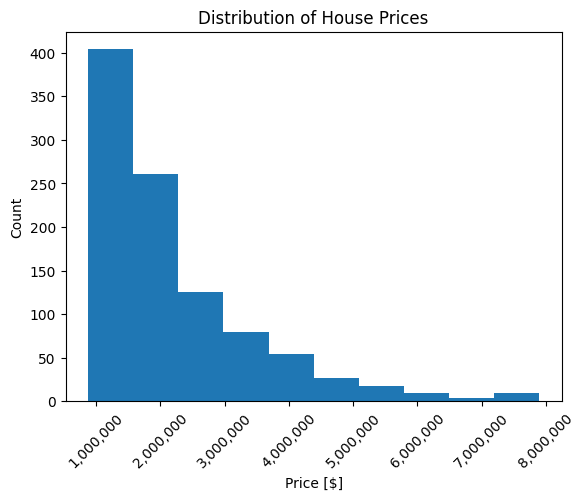

In [9]:
# Build histogram
plt.hist(df['price'])

# Label axes
plt.xlabel('Price [$]')
plt.ylabel("Count")

# Add title
plt.title("Distribution of House Prices")

# after plotting the data, format the labels
current_values = plt.gca().get_xticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.xticks(rotation=45)
plt.show()

In [10]:
# Examine area
area = df.area_m2

# view summary statistics
area.describe()

count     990.000000
mean      476.484667
std       237.476045
min       158.100000
25%       291.480000
50%       436.870000
75%       597.455000
max      1542.850000
Name: area_m2, dtype: float64

Text(0.5, 1.0, 'Distribution of House Sizes')

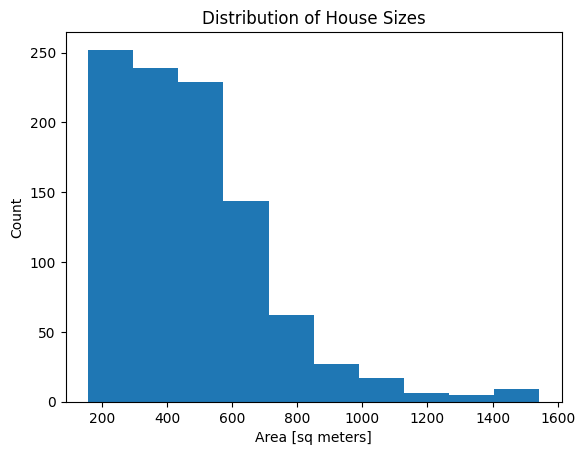

In [11]:
# plot histogram
plt.hist(df['area_m2'])
# set axis labels
plt.xlabel('Area [sq meters]')
plt.ylabel("Count")

# set tite
plt.title('Distribution of House Sizes')

Text(0.5, 1.0, 'Toronto, Ontario: Price vs. Area')

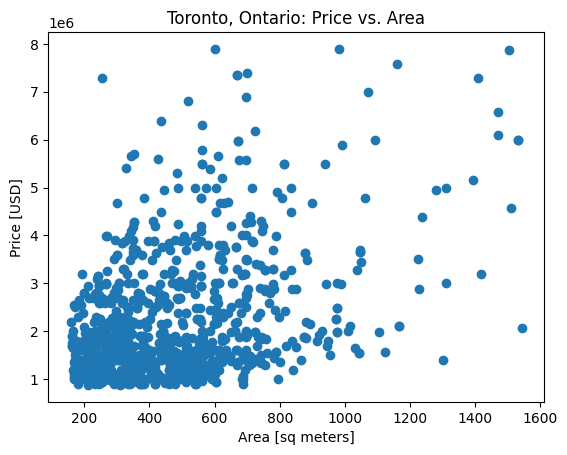

In [12]:
# Build scatter plot
plt.scatter(df["area_m2"], df["price"])


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Toronto, Ontario: Price vs. Area")



In [13]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,
    lat='lat',
    lon='lon',
    color='price',
    hover_data=['community_name']
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

Most houses are near the waterfront

<AxesSubplot: >

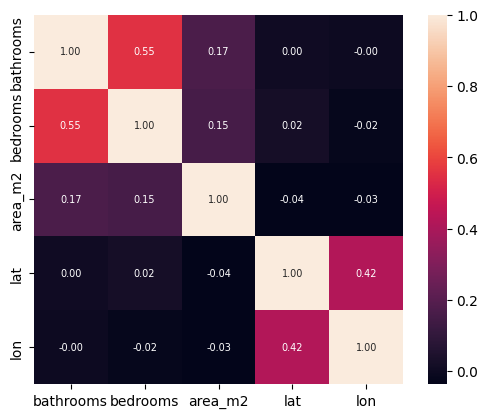

In [14]:
corr = df.select_dtypes('number').drop(columns='price').corr()
sns.heatmap(corr,
            cbar=True,
            annot=True,
            square=True,
            fmt='.2f',
            annot_kws={'size': 7})

### Split

In [15]:
# define target variable
y = df['price']
# define features
X = df.drop('price', axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)

## Build Model

### Baseline

In [16]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_pred_baseline, y_train)
print(f"Mean apt price: ${y_mean.round(2)}")
print(f"Baseline MAE: ${baseline_mae.round(2)}")

Mean apt price: $2167971.66
Baseline MAE: $942914.18


If we always predicted that a house price is $2,167,971.66, our predictions would be off by an average of $942,914.18. It also tells us that our model needs to have mean absolute error below $942,914.18 in order to be useful.

### Data pre-processing

##### Separate categorical and numerical columns

In [17]:
# create category columns selector
cat_selector = make_column_selector(dtype_include=object)
# create numerical columns selector
num_selector = make_column_selector(dtype_include=np.number)

print(cat_selector(X))
print(num_selector(X))


['community_name']
['bathrooms', 'bedrooms', 'area_m2', 'lat', 'lon']


##### Pipeline to preprocess tree models

In [18]:
# create categorical processor for tree models
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
# create numerical processor for tree models
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)
# create combined preprocessor for tree models
tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
# display tree preprocessor
tree_preprocessor


ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f6790>),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f67c0>)])

##### Pipeline to preprocess linear models

In [19]:
# create categorical columns processor for linear models
cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
# create numerical columns processor for linear models
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)
# create combined preprocessor for linear models
linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
# display linear preprocessor
linear_preprocessor


ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f6790>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f67c0>)])

##### The models

In [20]:
# instantiate lasso model
lasso_model = Lasso(alpha=0.1, random_state=10)
# instantiate linear regression model
lin_model = LinearRegression()
# instantiate random forrest model
rf_model = RandomForestRegressor(n_estimators=25,random_state=2)
# instantiate gradient boosting model
gbdt_model = GradientBoostingRegressor(max_depth=4,subsample=0.9,max_features=0.75,n_estimators=200,random_state=2)

##### Stack of predictors on Toronto housing dataset

In [21]:
# create pipeline for lasso model
lasso_pipeline = make_pipeline(linear_preprocessor, lasso_model)
# display pipeline
lasso_pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f6790>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f67c0>)])),
                ('lasso', Lasso(alpha=0.1, random_state=10))])

In [22]:
# create pipeline for linear regression model
linear_pipeline = make_pipeline(linear_preprocessor, lin_model)
# display pipeline
linear_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f6790>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f67c0>)])),
                ('linearregression', LinearRegression())])

In [23]:
# create pipeline for random forrest model
rf_pipeline = make_pipeline(
    tree_preprocessor, rf_model)
# display pipeline
rf_pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f6790>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f67c0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=25, random_state=2))])

In [24]:
# create pipeline for gradient boosting model
gbdt_pipeline = make_pipeline(
    tree_preprocessor, gbdt_model
)
# display pipeline
gbdt_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f6790>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f67c0>)])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=4, max_features=0.75,
                                           n_estimators=200, random_state=2,
                                           subsample=0.9))])

##### Defining stacking regressor

In [25]:
# create a list of estimators for stacking regressor
estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
    ("Linear Regression", linear_pipeline)
    
]
# instantiate stacking regressor
stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=RidgeCV())
# display stacking regressor
stacking_regressor


StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f6790>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_v...
                                                                                                  StandardScaler()),
                                                                                                 ('simpleimputer',
                                                                                                  SimpleImputer(add_indicator=True))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f6790>),
                                                                                ('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe65a5f67c0>)])),
                                               ('linearregression',
                                                LinearRegression())]))],
                  final_estimator=RidgeCV())

### Evaluating Multiple Models

#### Visualizing regression model performance

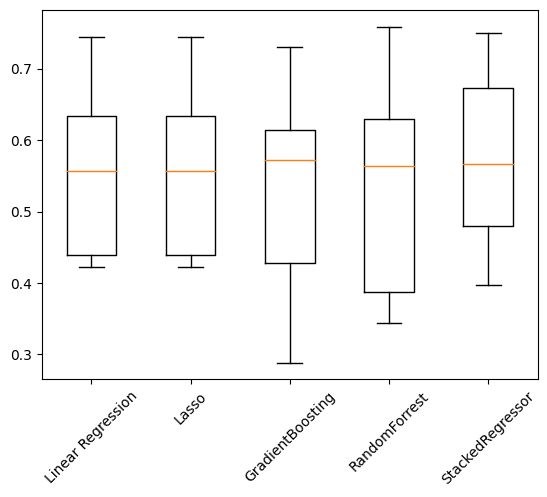

In [26]:
# create dictionary of pipelines
pipelines = {"Linear Regression": linear_pipeline,  "Lasso": lasso_pipeline,
          "GradientBoosting": gbdt_pipeline, "RandomForrest": rf_pipeline, "StackedRegressor": stacking_regressor}
# define empty list
results = []
# iterate through each pipeline
for pipeline in pipelines.values():
    # create KFold object
    kf = KFold(n_splits=10, random_state=10, shuffle=True)

    # Perform cross-validation for r squared
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf)

    # Append the results
    results.append(cv_scores)
  

# Create a box plot of the results
plt.boxplot(results, labels=pipelines.keys())
plt.xticks(rotation=45)
plt.show()

    

All models performed to a similar standard but the GradientBoosting model performed the best. That is, it generalized to the model the most.

#### Predicting on the Test Set

In [27]:
# create dictionary of pipeplines
pipelines = {"Lasso": lasso_pipeline,
          "GradientBoosting": gbdt_pipeline, "RandomForrest": rf_pipeline, "Stacked": stacking_regressor,
          "LinearRegression": linear_pipeline}

# iterate through the dictionary of pipelines
for name, pipeline in pipelines.items():

  # Iterate
  
  # Fit the model to the training data
  pipeline.fit(X_train, y_train)
  
  
  # Evaluate

  # Make predictions on the test set
  y_pred = pipeline.predict(X_test)
  mae_test = mean_absolute_error(y_pred, y_test)
  print("{} Test MAE: {}".format(name, round(mae_test, 2)))

  # calculate accuracy
  accuracy = pipeline.score(X_test, y_test)
  print("{} accuracy: {}".format(name, accuracy))

  # Calculate the test_rmse
  test_rmse = MSE(y_test, y_pred) ** (1/2)
  print("{} Test Set RMSE: {}".format(name, test_rmse))
  print('\n')


Lasso Test MAE: 592392.19
Lasso accuracy: 0.5373801386299445
Lasso Test Set RMSE: 876946.6447553638


GradientBoosting Test MAE: 591589.03
GradientBoosting accuracy: 0.5118012882708822
GradientBoosting Test Set RMSE: 900864.240855171


RandomForrest Test MAE: 585504.67
RandomForrest accuracy: 0.5055577219393124
RandomForrest Test Set RMSE: 906606.5096704293


Stacked Test MAE: 550548.49
Stacked accuracy: 0.5638385180558829
Stacked Test Set RMSE: 851500.0711961578


LinearRegression Test MAE: 592391.77
LinearRegression accuracy: 0.5373801611595237
LinearRegression Test Set RMSE: 876946.6234017204




A Stacked regressor model is the best model with an accuracy of about 56%. But the Linear regression model is the best singular model with an accuracy of about 56%

## Communicate Results

In [28]:
# define model intercept
intercept = lin_model.intercept_.round(2)
print(f"The intercept is ${intercept}")

# define model coefficients
coefficients = lin_model.coef_.round()

# get feature names
features = linear_pipeline[:-1].get_feature_names_out()

# define feature importance series
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
print(feat_imp)


The intercept is $2434960.65
pipeline__lat                                                        10502.0
pipeline__lon                                                       -24844.0
onehotencoder__community_name_Willowdale East                       -37309.0
pipeline__missingindicator_lat                                       56610.0
pipeline__missingindicator_lon                                       56610.0
onehotencoder__community_name_The Beaches                           -61599.0
onehotencoder__community_name_Bedford Park-Nortown                   84714.0
pipeline__bedrooms                                                  -86356.0
onehotencoder__community_name_Newtonbrook East                     -198452.0
pipeline__area_m2                                                   272908.0
onehotencoder__community_name_other                                -349576.0
onehotencoder__community_name_Willowdale West                      -359956.0
onehotencoder__community_name_Islington-City Ce

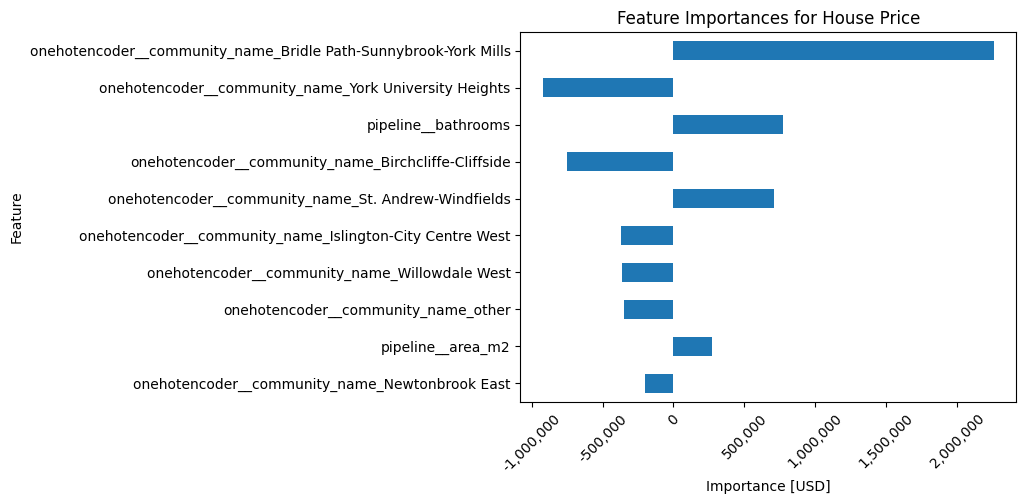

In [29]:
# Build bar chart
feat_imp
feat_imp.tail(10).plot(
    kind="barh")

# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")

# Add title
plt.title("Feature Importances for House Price")

# after plotting the data, format the labels
current_values = plt.gca().get_xticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.xticks(rotation=45)
plt.show()


## Deployment

In [30]:
# define prediction function
def make_prediction(area, bedrooms, bathrooms, lat, lon, community):
    data = {
        'area_m2': area,
        'bedrooms': bedrooms,
        'bathrooms': bathrooms,
        'lat': lat,
        'lon': lon,
        'community_name': community
    }
    df = pd.DataFrame(data, index=[0])
    prediction = pipeline.predict(df).round(2)[0]
    return f"Predicted house price: ${prediction}"


In [31]:
# create interactive dashboard
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["area_m2"].min(),
        max=X_train["area_m2"].max(),
        value=X_train["area_m2"].mean(),
    ),
    bedrooms=FloatText(
        value=3,
        description='bedrooms',
        disabled=False
    ),
    bathrooms=FloatText(
        value=3,
        description='bathrooms',
        disabled=False
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    community=Dropdown(options=sorted(
        X_train['community_name'].astype(str).unique())),
)


interactive(children=(IntSlider(value=484, description='area', max=1542, min=158), FloatText(value=3.0, descri…

<function __main__.make_prediction(area, bedrooms, bathrooms, lat, lon, community)>